<a href="https://colab.research.google.com/github/calculus-github/test/blob/main/OpenAI_Point_E_Text_to_3D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Tue Dec 20 19:04:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    26W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
! pip install plotly -q

In [ ]:
!git clone https://github.com/openai/point-e

Cloning into 'point-e'...
remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 53 (delta 5), reused 53 (delta 5), pack-reused 0
Unpacking objects: 100% (53/53), done.


In [ ]:
%cd point-e

/content/point-e


In [ ]:
! pip install -e .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/point-e
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-install-y1ho8jbm/clip_4abd5645f86c45b6878ba82e2cb6aaf4
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-install-y1ho8jbm/clip_4abd5645f86c45b6878ba82e2cb6aaf4
     |████████████████████████████████| 88 kB 4.0 MB/s 
     |████████████████████████████████| 53 kB 1.8 MB/s 
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369408 sha256=c48aba6a5ab3437e6f6b9f5871f75940432a8a4d08e90c3a5471812128e51994
  Stored in directory: /tmp/pip-ephem-wheel-cache-2anckbg0/wheels/ab/4f/3a/5e51521b55997aa6f0690e095c08824219753128ce8d9969a3
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116949 sha256=d276b98a75d873872e0f3afc31bf33723f488a5bf5ebd23cf1765d26cabdfceb
  Stored in directory: /root/.cache/pip/wheels/5b/eb/43/7295e71293b218ddfd627f935229bf54af

### Imports

In [ ]:
import torch
from tqdm.auto import tqdm

from point_e.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config
from point_e.diffusion.sampler import PointCloudSampler
from point_e.models.download import load_checkpoint
from point_e.models.configs import MODEL_CONFIGS, model_from_config
from point_e.util.plotting import plot_point_cloud

### Models

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('creating base model...')
base_name = 'base40M-textvec'
base_model = model_from_config(MODEL_CONFIGS[base_name], device)
base_model.eval()
base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

print('creating upsample model...')
upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
upsampler_model.eval()
upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

print('downloading base checkpoint...')
base_model.load_state_dict(load_checkpoint(base_name, device))

print('downloading upsampler checkpoint...')
upsampler_model.load_state_dict(load_checkpoint('upsample', device))

creating base model...


100%|████████████████████████████████████████| 890M/890M [00:05<00:00, 168MiB/s]


creating upsample model...
downloading base checkpoint...


  0%|          | 0.00/161M [00:00<?, ?iB/s]

downloading upsampler checkpoint...


  0%|          | 0.00/162M [00:00<?, ?iB/s]

<All keys matched successfully>

In [ ]:
sampler = PointCloudSampler(
    device=device,
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=[1024, 4096 - 1024],
    aux_channels=['R', 'G', 'B'],
    guidance_scale=[3.0, 0.0],
    model_kwargs_key_filter=('texts', ''), # Do not condition the upsampler at all
)

In [ ]:
# Set a prompt to condition on.
prompt = 'a grey boeing 737'

# Produce a sample from the model.
samples = None
for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(texts=[prompt]))):
    samples = x

0it [00:00, ?it/s]

In [ ]:
pc = sampler.output_to_point_clouds(samples)[0]

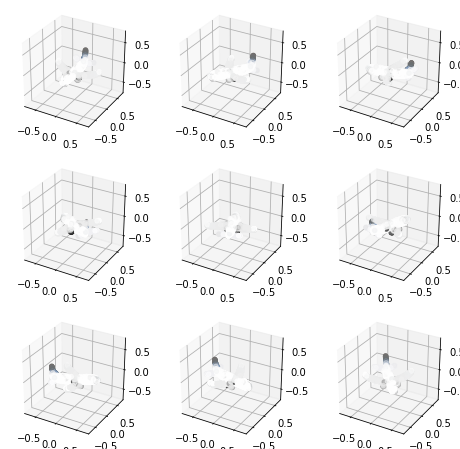

In [ ]:

fig = plot_point_cloud(pc, grid_size=3, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))

In [ ]:
import plotly.graph_objects as go


In [ ]:
fig_plotly = go.Figure(
        data=[
            go.Scatter3d(
                x=pc.coords[:,0], y=pc.coords[:,1], z=pc.coords[:,2], 
                mode='markers',
                marker=dict(
                  size=2,
                  color=['rgb({},{},{})'.format(r,g,b) for r,g,b in zip(pc.channels["R"], pc.channels["G"], pc.channels["B"])],
              )
            )
        ],
        layout=dict(
            scene=dict(
                xaxis=dict(visible=False),
                yaxis=dict(visible=False),
                zaxis=dict(visible=False)
            )
        ),
    )

In [ ]:
fig_plotly.show(renderer="colab")
